# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf

# Importing & Adjusting Dataset

In [2]:
dataset_cols = [
    "bike_count",
    "hour",
    "temp",
    "humidity",
    "wind",
    "visibility",
    "dew_pt_temp",
    "radiation",
    "rain",
    "snow",
    "functional",
]
# Dropping Date, Holiday & Seasons Cloumns
df = pd.read_csv("SeoulBikeData.csv", encoding="latin-1").drop(
    ["Date", "Holiday", "Seasons"], axis=1
)
df.columns = dataset_cols
# Check if there are any missing values in the entire DataFrame
any_missing_values = df.isna().any().any()
print(f"Missing values in the entire DataFrame: {any_missing_values}")
# Converting functional column into Zero's & One's
df["functional"] = (df["functional"] == "Yes").astype(int)
# Modifying then dropping the hour Column
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)
# Displaying dataset after modification
df.head()

Missing values in the entire DataFrame: False


,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


# Dropping Unrelated ColumnsWind, Visibility & Functional 

In [3]:
df = df.drop(["wind","visibility","functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Splitting into Train, Test & Valid

In [4]:
train, val, test = np.split(df.sample(frac=1), [int(len(df) * 0.6), int(len(df) * 0.8)])

e:\Courses\Machine-Learning-for-Everybody\.conda\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
def get_xy(dataframe, y_label, x_labels=None):
    # Make a deep copy of the input dataframe to avoid modifying the original
    dataframe = copy.deepcopy(dataframe)

    # Check if specific X labels are provided, otherwise use all columns except y_label
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        # If only one X label is provided, reshape it to a 2D array with a single column
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            # If multiple X labels are provided, use them as-is
            X = dataframe[x_labels].values

    # Extract the y values (dependent variable) and reshape to a 2D array with a single column
    y = dataframe[y_label].values.reshape(-1, 1)

    # Combine X and y into a single array for easy use in machine learning algorithms
    data = np.hstack((X, y))

    # Return the formatted data along with individual X and y
    return data, X, y

In [6]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

# Building NN

## Plot Loss

In [7]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

## Normalizing the data

In [8]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

## Building Layer

In [9]:
nn_model = tf.keras.Sequential(
    [
        temp_normalizer,
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="relu"),

    ]
)

# Compiling Network

In [10]:
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error"
)

In [11]:
history = nn_model.fit(
    X_train_temp,y_train_temp,
    verbose=0,
    epochs=100,
    validation_data= (X_val_temp,y_val_temp)
    )

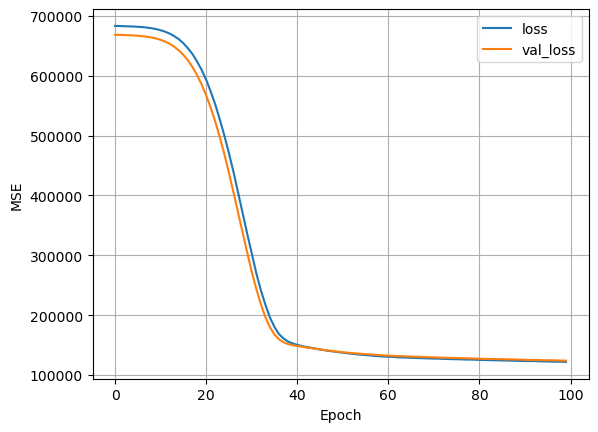

In [12]:
plot_loss(history)

4/4 [==============================] - 1s 11ms/step


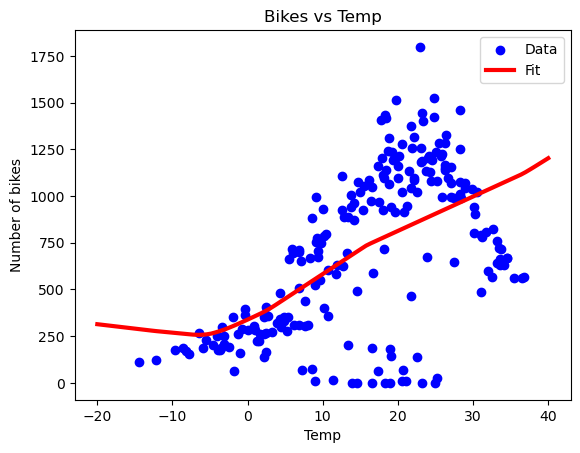

In [13]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(
    x,
    nn_model.predict(np.array(x).reshape(-1, 1)),
    label="Fit",
    color="red",
    linewidth=3,
)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()